# Intraday Option Vol Surfaces

<b> YouTube Tutorial </b> (Published: Sep 8, 2022): https://youtu.be/b7gP1UW8zzE

In today's tutorial we investigate how you can use ThetaData's API to retreive historical options data for end-of-day, and both intraday trades and quotes. We will create volatility surfaces use an interpolation method (B-Splines) to compare surfaces between the morning (10:00) implied volalitity and afternoon (14:00) implied volatility surfaces.

In [ ]:
!pip install thetadata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import concurrent.futures as cf
import matplotlib.pyplot as plt

from datetime import timedelta, datetime, date
from thetadata import ThetaClient, OptionReqType, OptionRight, DateRange, DataType

To use the [ThetaData API](https://www.thetadata.net/) you will have to sign up for an account. Then you will pass your username and password as strings within the ThetaClient class init params.

In [ ]:
your_username = ''
your_password = ''

## Get all Expirations for SPY Options

In [ ]:
def get_expirations(root_ticker) -> pd.DataFrame:
    """Request expirations from a particular options root"""
    # Create a ThetaClient
    client = ThetaClient(username=your_username, passwd=your_password, timeout=15)

    # Connect to the Terminal
    with client.connect():

        # Make the request
        data = client.get_expirations(
            root=root_ticker,
        )

    return data

In [ ]:
root_ticker = 'SPY'
expirations = get_expirations(root_ticker)

In [ ]:
time_now = datetime.today()
time_now

datetime.datetime(2022, 9, 7, 7, 58, 45, 578616)

In [ ]:
exp_dates = expirations[expirations > time_now + timedelta(days=7)]
exp_dates

310   2022-09-16
311   2022-09-19
312   2022-09-21
313   2022-09-23
314   2022-09-26
315   2022-09-28
316   2022-09-30
317   2022-10-03
318   2022-10-05
319   2022-10-07
320   2022-10-21
321   2022-11-18
322   2022-12-16
323   2022-12-30
324   2023-01-20
325   2023-03-17
326   2023-03-31
327   2023-06-16
328   2023-06-30
329   2023-09-15
330   2023-12-15
331   2024-01-19
332   2024-06-21
333   2024-12-20
dtype: datetime64[ns]

## Get all Strikes for each SPY Option

In [ ]:
def get_strikes(root_ticker, expiration_date) -> pd.DataFrame:
    """Request strikes from a particular option contract"""
    # Create a ThetaClient
    client = ThetaClient(username=your_username, passwd=your_password, timeout=15)

    # Connect to the Terminal
    with client.connect():

        # Make the request
        data = client.get_strikes(
            root=root_ticker,
            exp=expiration_date
        )

    return data

In [ ]:
root_ticker = 'SPY'
exp_date = date(2022,9,16)
strikes = get_strikes(root_ticker, exp_date)
strikes

0      320000
1      384000
2      448000
3      512000
4      640000
        ...  
278    470000
279    235000
280    363000
281    427000
282    491000
Length: 283, dtype: object

In [ ]:
root_ticker = 'SPY'
all_strikes = {}
for exp_date in exp_dates:
    all_strikes[exp_date] = pd.to_numeric(get_strikes(root_ticker, exp_date))

## Find combined Strikes across expiry dates

Using set intersection of all strikes across SPY Options contracts.

Save strikes down with pickle for use later.

In [ ]:
combined_strikes = [list(strikes) for strikes in all_strikes.values()]
vol_surface_strikes = set.intersection(*map(set,combined_strikes))
vol_surface_strikes

{330000,
 335000,
 340000,
 345000,
 350000,
 355000,
 360000,
 365000,
 370000,
 375000,
 380000,
 385000,
 390000,
 395000,
 400000,
 405000,
 410000,
 415000,
 420000,
 425000,
 430000,
 435000,
 440000,
 445000,
 450000,
 455000,
 460000,
 465000,
 470000,
 475000}

In [ ]:
with open('vol_surface_strikes.pkl', 'wb') as f:
    pickle.dump(vol_surface_strikes, f)

In [ ]:
with open('vol_surface_strikes.pkl', 'rb') as f:
    vol_surface_strikes = pickle.load(f)

vol_surface_strikes = list(vol_surface_strikes)
vol_surface_strikes.sort()
vol_surface_strikes

[330000,
 335000,
 340000,
 345000,
 350000,
 355000,
 360000,
 365000,
 370000,
 375000,
 380000,
 385000,
 390000,
 395000,
 400000,
 405000,
 410000,
 415000,
 420000,
 425000,
 430000,
 435000,
 440000,
 445000,
 450000,
 455000,
 460000,
 465000,
 470000,
 475000]

## Retreive EOD Options Data

In [ ]:
def end_of_day(root_ticker, exp_date, strike, from_date, to_date) -> pd.DataFrame:
    """Request end-of-day data"""
    # Create a ThetaClient
    client = ThetaClient(username=your_username, passwd=your_password, timeout=10)

    # Connect to the Terminal
    with client.connect():

        # Make the request
        data = client.get_hist_option(
            req=OptionReqType.EOD,
            root=root_ticker,
            exp=exp_date,
            strike=strike,
            right=OptionRight.CALL,
            date_range=DateRange(from_date, to_date),
        )

    return data

In [ ]:
root_ticker = 'SPY'
from_date = date(2022,8,26)
to_date = date(2022,8,31)
exp_date = exp_dates.tolist()[0]
strike = 420000
data = end_of_day(root_ticker, exp_date, int(int(strike)/1000), from_date, to_date)
data

,DataType.OPEN,DataType.HIGH,DataType.LOW,DataType.CLOSE,DataType.VOLUME,DataType.COUNT,DataType.DATE
0,7.39,7.67,2.36,2.40,22940,2489,2022-08-26
1,1.73,1.76,0.79,0.90,37721,1243,2022-08-30
2,1.01,1.17,0.52,0.53,19626,1036,2022-08-31


## Retreive Trades Data

In [ ]:
# Make the request
def trades(root_ticker, exp_date, strike, from_date, to_date) -> pd.DataFrame:
    """Request trade level data"""
    # Create a ThetaClient
    client = ThetaClient(username=your_username, passwd=your_password, timeout=10)

    # Connect to the Terminal
    with client.connect():

        data = client.get_hist_option(
            req=OptionReqType.TRADE,
            root=root_ticker,
            exp=exp_date,
            strike=strike,
            right=OptionRight.CALL,
            date_range=DateRange(from_date, to_date),
            progress_bar=False,
        )

    return data

In [ ]:
root_ticker = 'SPY'
exp_date = date(2022,9,16)
from_date = date(2022,8,31)
to_date = date(2022,8,31)
strike = 420000
data = trades(root_ticker, exp_date, int(int(strike)/1000), from_date, to_date)
data

,DataType.MS_OF_DAY,DataType.SEQUENCE,DataType.SIZE,DataType.CONDITION,DataType.PRICE,DataType.DATE
0,34200110,2449354,24,-126,1.01,2022-08-31
1,34200111,2449692,20,-126,0.99,2022-08-31
2,34200591,2498574,1,95,0.99,2022-08-31
3,34200845,2535481,4,95,0.99,2022-08-31
4,34202016,2765033,1,95,0.98,2022-08-31
...,...,...,...,...,...,...
1031,58322776,-1376599039,20,-122,0.54,2022-08-31
1032,58401141,-1375770724,3,18,0.54,2022-08-31
1033,58449294,-1375264974,1,18,0.54,2022-08-31
1034,58454035,-1375226981,5,18,0.54,2022-08-31


### Use MS_OF_DAY to Create DateTime

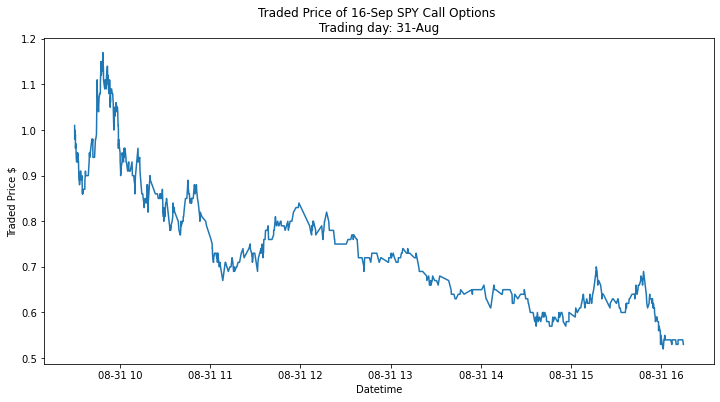

In [ ]:
data['DATETIME'] = data[DataType.DATE] + pd.TimedeltaIndex(data[DataType.MS_OF_DAY], unit='ms')
plt.figure(figsize=(12,6))
plt.title('Traded Price of 16-Sep SPY Call Options \n Trading day: 31-Aug ')
plt.xlabel('Datetime')
plt.ylabel('Traded Price $')
plt.plot(data['DATETIME'],data[DataType.PRICE])

## Retreive Quoted Intraday Options Prices

In [ ]:
# Make the request
def quotes(root_ticker, exp_date, strike, from_date, to_date, interval_size=0) -> pd.DataFrame:
    """Request quotes both bid/ask options data"""
    # Create a ThetaClient
    client = ThetaClient(username=your_username, passwd=your_password, timeout=10)

    # Connect to the Terminal
    with client.connect():

        data = client.get_hist_option(
            req=OptionReqType.QUOTE,
            root=root_ticker,
            exp=exp_date,
            strike=strike,
            right=OptionRight.CALL,
            date_range=DateRange(from_date, to_date),
            progress_bar=False,
            interval_size=interval_size
        )

    return data

In [ ]:
root_ticker = 'SPY'
exp_date = date(2022,9,16)
from_date = date(2022,8,31)
to_date = date(2022,8,31)
strike = 420000
data = quotes(root_ticker, exp_date, int(int(strike)/1000), from_date, to_date)
data

,DataType.MS_OF_DAY,DataType.BID_SIZE,DataType.BID_CONDITION,DataType.BID,DataType.BID_EXCHANGE,DataType.ASK_SIZE,DataType.ASK_CONDITION,DataType.ASK,DataType.ASK_EXCHANGE,DataType.DATE
0,28800803,0,65,0.00,50,0,65,0.00,50,2022-08-31
1,28800891,0,42,0.00,50,0,42,0.00,50,2022-08-31
2,28801030,0,60,0.00,50,0,60,0.00,50,2022-08-31
3,28801172,0,5,0.00,50,0,5,0.00,50,2022-08-31
4,28804766,0,5,0.00,50,0,5,0.00,50,2022-08-31
...,...,...,...,...,...,...,...,...,...,...
539581,58493037,562,42,0.53,50,368,47,0.54,50,2022-08-31
539582,58493258,562,42,0.53,50,332,47,0.54,50,2022-08-31
539583,58494681,562,42,0.53,50,290,69,0.54,50,2022-08-31
539584,58494755,562,42,0.53,50,381,47,0.54,50,2022-08-31


## Change interval size

Aggregate average BID/ASK Quotes on a 5 minute basis.

In [ ]:
interval_size = 5*60000
data = quotes(root_ticker, exp_date, int(int(strike)/1000), from_date, to_date, interval_size)
dt_date_ms = data[DataType.DATE] + pd.TimedeltaIndex(data[DataType.MS_OF_DAY], unit='ms')
data.insert(loc=0, column='DATETIME', value=dt_date_ms)
data

,DATETIME,DataType.MS_OF_DAY,DataType.BID_SIZE,DataType.BID_CONDITION,DataType.BID,DataType.BID_EXCHANGE,DataType.ASK_SIZE,DataType.ASK_CONDITION,DataType.ASK,DataType.ASK_EXCHANGE,DataType.DATE
0,2022-08-31 00:00:00,0,0,0,0.00,0,0,0,0.00,0,2022-08-31
1,2022-08-31 00:05:00,300000,0,0,0.00,0,0,0,0.00,0,2022-08-31
2,2022-08-31 00:10:00,600000,0,0,0.00,0,0,0,0.00,0,2022-08-31
3,2022-08-31 00:15:00,900000,0,0,0.00,0,0,0,0.00,0,2022-08-31
4,2022-08-31 00:20:00,1200000,0,0,0.00,0,0,0,0.00,0,2022-08-31
...,...,...,...,...,...,...,...,...,...,...,...
282,2022-08-31 23:30:00,84600000,562,42,0.53,50,381,47,0.54,50,2022-08-31
283,2022-08-31 23:35:00,84900000,562,42,0.53,50,381,47,0.54,50,2022-08-31
284,2022-08-31 23:40:00,85200000,562,42,0.53,50,381,47,0.54,50,2022-08-31
285,2022-08-31 23:45:00,85500000,562,42,0.53,50,381,47,0.54,50,2022-08-31


In [ ]:
morning_int = 120
afternoon_int = 168
morning = data['DATETIME'][morning_int]
afternoon = data['DATETIME'][afternoon_int]
print("Morning Interval", morning, "\nAfternoon Interval", afternoon)

Morning Interval 2022-08-31 10:00:00 
Afternoon Interval 2022-08-31 14:00:00


In [ ]:
data.iloc[afternoon_int]

DATETIME                  2022-08-31 14:00:00
DataType.MS_OF_DAY                   50400000
DataType.BID_SIZE                        6247
DataType.BID_CONDITION                     42
DataType.BID                             0.64
DataType.BID_EXCHANGE                      50
DataType.ASK_SIZE                        1429
DataType.ASK_CONDITION                     42
DataType.ASK                             0.65
DataType.ASK_EXCHANGE                      50
DataType.DATE             2022-08-31 00:00:00
Name: 168, dtype: object

## Calculate Weighted Mid Price (Micro-Price)

https://quant.stackexchange.com/questions/50651/how-to-understand-micro-price-aka-weighted-mid-price

$\Large P_{m} = P_a \frac{V_b}{(V_a + V_b)} + P_b  \frac{V_a}{(V_a + V_b)}$

In [ ]:
def weighted_mid_price(row):
    try:
        V_mid = row[DataType.ASK_SIZE] + row[DataType.BID_SIZE]
        x_a = row[DataType.ASK_SIZE]/V_mid
        x_b = 1 - x_a
        return row[DataType.ASK]*x_a + row[DataType.BID]*x_b
    except:
        return np.nan

In [ ]:
midprices = data.apply(weighted_mid_price, axis=1)
midprices

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
        ...   
282    0.53404
283    0.53404
284    0.53404
285    0.53404
286    0.53404
Length: 287, dtype: float64

## Create request for 10:00 and 14:00 Weighted Mid Prices

In [ ]:
# Make the request
def get_morn_noon_quotes(root_ticker, exp_date, strike, from_date, to_date, interval_size=0) -> pd.DataFrame:
    """Returns morning and afternoon weighter mid prices at 1000 and 1400 respectively"""
    # Create a ThetaClient
    client = ThetaClient(username=your_username, passwd=your_password, timeout=10)

    # Connect to the Terminal
    with client.connect():

        data = client.get_hist_option(
            req=OptionReqType.QUOTE,
            root=root_ticker,
            exp=exp_date,
            strike=strike,
            right=OptionRight.CALL,
            date_range=DateRange(from_date, to_date),
            progress_bar=False,
            interval_size=interval_size
        )

    morning_int = 120
    afternoon_int = 168

    midprices = data.apply(weighted_mid_price, axis=1)

    return midprices[morning_int], midprices[afternoon_int]

### Multi-threading Responses to ThetaData API

Now we explore using current.futures module to perform multi-threading and processing of responses using ThetaData API.
1. We need to create a function that we can call with our specific parameters of interest
2. We need to know the maximium number of threads our computer has

In [ ]:
def retrieve_eod_data(root_ticker, exp_date, strike, from_date, to_date, interval_size):
    try:
        morning, afternoon = get_morn_noon_quotes(root_ticker, exp_date, int(int(strike)/1000), from_date, to_date, interval_size)
        print("  ", strike," data")
        datas[exp_date][strike] = [morning, afternoon]
    except:
        datas[exp_date][strike] = [np.nan, np.nan]
        print("  ", strike," no data")

In [ ]:
root_ticker = 'SPY'
from_date = date(2022,8,31)
to_date = date(2022,8,31)
interval_size = 5*60000

datas = {}
for exp_date in exp_dates:
    print(exp_date)
    start = time.time()
    datas[exp_date] = {}
    executor = cf.ThreadPoolExecutor(8)
    futures = [executor.submit(retrieve_eod_data, root_ticker, exp_date, strike, from_date, to_date, interval_size)
               for strike in vol_surface_strikes]
    cf.wait(futures)
    end = time.time()
    print('  time taken {:.2f} s'.format(end-start))

2022-09-16 00:00:00
   365000  data
   360000  data
   350000  data
   355000  data
   375000  data
   380000  data
   370000  data
   385000  data
   395000  data
   390000  data
   400000  data
   405000  data
   345000  data
   410000  data
   415000  data
   335000  data
   420000  data
   340000  data
   330000  data
   425000  data
   435000  data
   445000  data
   455000  data
   460000  data
   475000  data
   470000  data
   440000  data
   430000  data
   465000  data
   450000  data
  time taken 9.44 s
2022-09-19 00:00:00
   330000  data
   350000  data
   340000  data
   360000  data
   355000  data
   390000  data
   345000  data
   370000  data
   395000  data
   365000  data
   405000  data
   400000  data
   380000  data
   410000  data
   415000  data
   420000  data
   385000  data
   335000  data
   425000  data
   435000  data
   375000  data
   440000  data
   460000  data
   450000  data
   455000  data
   465000  data
   470000  data
   430000  data
   475000  d

## Save Data Down with Pickle

In [ ]:
with open('datas.pkl', 'wb') as f:
    pickle.dump(datas, f)

## Arrange price data

Arrange data correctly in numpy array ready for calculating implied volatility.

In [ ]:
with open('datas.pkl', 'rb') as f:
    datas = pickle.load(f)

# datas

price_morn_arr = []
price_arvo_arr = []
for exp_date, prices in datas.items():
    morn_arr = [price[0] for strike, price in sorted(prices.items())]
    arvo_arr = [price[1] for strike, price in sorted(prices.items())]
    # strikes = [strike for strike, price in sorted(prices.items())]
    price_morn_arr.append(morn_arr)
    price_arvo_arr.append(arvo_arr)

price_morn_arr = np.array(price_morn_arr)
price_arvo_arr = np.array(price_arvo_arr)

np.shape(price_morn_arr), price_morn_arr[0,:], np.shape(price_arvo_arr), price_arvo_arr[0,:]

((24, 30),
 array([7.01100000e+01, 6.52366667e+01, 6.01463636e+01, 5.52000000e+01,
        5.02850000e+01, 4.53950000e+01, 4.04657534e+01, 3.56719298e+01,
        3.10800000e+01, 2.64179221e+01, 2.20700000e+01, 1.79300000e+01,
        1.40981799e+01, 1.06144898e+01, 7.63912281e+00, 5.13222989e+00,
        3.20226667e+00, 1.83424453e+00, 9.69858511e-01, 4.79524242e-01,
        2.27344920e-01, 1.04077911e-01, 5.53045285e-02, 3.94367461e-02,
        2.93031586e-02, 1.58662481e-02, 1.87661406e-02, 1.00000000e-02,
        1.00000000e-02, 1.00000000e-02]),
 (24, 30),
 array([6.72382609e+01, 6.24056250e+01, 5.74466667e+01, 5.23700000e+01,
        4.74838462e+01, 4.26482609e+01, 3.77037500e+01, 3.29803175e+01,
        2.84450000e+01, 2.38727778e+01, 1.96974510e+01, 1.55985714e+01,
        1.20543807e+01, 8.80090909e+00, 6.07553571e+00, 3.91844961e+00,
        2.30779390e+00, 1.26931973e+00, 6.41861647e-01, 3.29797536e-01,
        1.54107782e-01, 8.99976450e-02, 4.83899244e-02, 2.42442004e-02,


## Create DataFrame for Option Maturity, Strike and Prices

In [ ]:
!pip install py-vollib-vectorized

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install py-vollib-vectorized
from scipy.interpolate import griddata
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

maturity = np.array([(exp_date-time_now).days/365.25 for exp_date in exp_dates])
strikes = np.array(vol_surface_strikes)/1000

volSurfaceMorn = pd.DataFrame(price_morn_arr, index = maturity, columns = strikes)
volSurfaceArvo = pd.DataFrame(price_arvo_arr, index = maturity, columns = strikes)
volSurfaceLongMorn = volSurfaceMorn.melt(ignore_index=False).reset_index()
volSurfaceLongArvo = volSurfaceArvo.melt(ignore_index=False).reset_index()
volSurfaceLongMorn.columns = ['maturity', 'strike', 'price']
volSurfaceLongArvo.columns = ['maturity', 'strike', 'price']

s,m = np.meshgrid(strikes, maturity)

np.shape(s) == np.shape(m) == np.shape(price_morn_arr)

True

In [ ]:
np.shape(m), m[:,0]

((24, 30), array([0.02190281, 0.03011636, 0.03559206, 0.04106776, 0.04928131,
        0.05475702, 0.06023272, 0.06844627, 0.07392197, 0.07939767,
        0.11772758, 0.19438741, 0.27104723, 0.30937714, 0.36687201,
        0.52019165, 0.55852156, 0.76933607, 0.80766598, 1.01848049,
        1.26762491, 1.36344969, 1.78507871, 2.28336756]))

## Interpolation of Price Surface

Using scipy griddata we can interpolate our multivariate price array and return a mesh for plotting.

In [ ]:
strikes2 = np.linspace(strikes[0],strikes[-1],20)
maturity2 = np.linspace(maturity[0],maturity[-1],20)
s2,m2 = np.meshgrid(strikes2, maturity2)


price_intpol_morn = griddata((s[~np.isnan(price_morn_arr)], m[~np.isnan(price_morn_arr)]),
                                price_morn_arr[~np.isnan(price_morn_arr)], (s2,m2), method='linear')

price_intpol_arvo = griddata((s[~np.isnan(price_arvo_arr)], m[~np.isnan(price_arvo_arr)]),
                                price_arvo_arr[~np.isnan(price_arvo_arr)], (s2,m2), method='linear')

priceSurfaceMorn = pd.DataFrame(price_intpol_morn, index = maturity2, columns = strikes2)
priceSurfaceArvo = pd.DataFrame(price_intpol_arvo, index = maturity2, columns = strikes2)
priceSurfaceMorn = priceSurfaceMorn.melt(ignore_index=False).reset_index()
priceSurfaceArvo = priceSurfaceArvo.melt(ignore_index=False).reset_index()
priceSurfaceMorn.columns = ['maturity', 'strike', 'interpolation']
priceSurfaceArvo.columns = ['maturity', 'strike', 'interpolation']

### Using Plotly to graph 3D surface

#### First only looking at the Morning Price Surface

In [ ]:
import plotly.graph_objects as go
from plotly.graph_objs import Surface
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()
fig = go.Figure(data=[go.Mesh3d(x=priceSurfaceMorn.maturity, y=priceSurfaceMorn.strike, z=priceSurfaceMorn.interpolation, color='mediumblue', opacity=0.55)])
fig.add_scatter3d(x=volSurfaceLongMorn.maturity, y=volSurfaceLongMorn.strike, z=volSurfaceLongMorn.price, mode='markers')
fig.update_layout(
    title_text='10:00 SPY Quoted Market Prices (Markers) vs 2d Interpolation (Mesh)',
    scene = dict(xaxis_title='TIME (Years)',
                    yaxis_title='STRIKES ($)',
                    zaxis_title='SPY OPTION PRICE ($)'),
    height=800,
    width=800
)
fig.show(renderer="colab")

Output hidden; open in https://colab.research.google.com to view.

#### Plotting both the Morning and Afternoon Price Surfaces

In [ ]:
import plotly.graph_objects as go
from plotly.graph_objs import Surface
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()
fig = go.Figure(data=[go.Mesh3d(x=priceSurfaceMorn.maturity, y=priceSurfaceMorn.strike, z=priceSurfaceMorn.interpolation, color='mediumblue', opacity=0.55),
                         go.Mesh3d(x=priceSurfaceArvo.maturity, y=priceSurfaceArvo.strike, z=priceSurfaceArvo.interpolation, color='red', opacity=0.55)])
# fig.add_scatter3d(x=volSurfaceLongMorn.maturity, y=volSurfaceLongMorn.strike, z=volSurfaceLongMorn.price, mode='markers')
fig.update_layout(
    title_text='10:00 vs 14:00 SPY Quoted Market Prices (Markers) vs 2d Interpolation (Mesh)',
    scene = dict(xaxis_title='TIME (Years)',
                    yaxis_title='STRIKES ($)',
                    zaxis_title='SPY OPTION PRICE ($)'),
    height=800,
    width=800
)
fig.show(renderer="colab")

Output hidden; open in https://colab.research.google.com to view.

## Calculation of Volatility Surface

Volatility array calculation from price_arr numpy array.
Create clean DataFrame for vol surface.

In [ ]:
price_morn = 399.67
price_arvo = 396.75

s,m = np.meshgrid(strikes, maturity)
volatility_morn = implied_vol(price_morn_arr, K=s, t=m, S=price_morn, r=0.01, flag='c', q=0, return_as='numpy', on_error='ignore')
volatility_arvo = implied_vol(price_arvo_arr, K=s, t=m, S=price_arvo, r=0.01, flag='c', q=0, return_as='numpy', on_error='ignore')

vol_morn_arr = np.copy(volatility_morn)*100
vol_arvo_arr = np.copy(volatility_arvo)*100

vol_morn_arr[(vol_morn_arr < 1) | (vol_morn_arr > 120)] = np.nan
vol_arvo_arr[(vol_arvo_arr < 1) | (vol_arvo_arr > 120)] = np.nan

volSurfaceLongMorn['volatility'] = vol_morn_arr
volSurfaceLongArvo['volatility'] = vol_arvo_arr

volSurfaceLongMorn = volSurfaceLongMorn[~( (np.isnan(volSurfaceLongMorn['price'])) | (volSurfaceLongMorn['volatility']) > 60)]
volSurfaceLongArvo = volSurfaceLongArvo[~( (np.isnan(volSurfaceLongArvo['price'])) | (volSurfaceLongArvo['volatility']) > 60)]

vol_morn_arr = vol_morn_arr.reshape(np.shape(price_morn_arr))
vol_arvo_arr = vol_arvo_arr.reshape(np.shape(price_arvo_arr))

vol_morn_arr[price_morn_arr == np.nan] = np.nan
vol_arvo_arr[price_arvo_arr == np.nan] = np.nan

vol_morn_arr[:,0], vol_arvo_arr[:,0]

(array([67.11537449, 56.67863398, 52.19690753, 47.94846034, 43.8503303 ,
        41.95497466, 40.22089524, 37.98431784, 36.99455918, 36.25295732,
        32.60597058, 33.06889439, 33.0603609 , 31.89029585, 31.20802394,
        31.91170921, 31.46886372, 31.64776595, 31.2594301 , 31.1026933 ,
        30.62453932, 30.04865143, 29.7341548 , 28.84224761]),
 array([66.3738004 , 56.73284947, 52.34668187, 48.87985036, 44.33059133,
        42.35508802, 38.72642987, 38.20258236,         nan, 36.51279965,
        31.1289763 , 33.37676481, 33.27705708, 32.09491728, 31.42195798,
        32.06576267, 31.61539855, 31.7416338 , 31.3512733 , 31.17977444,
        30.69613359, 30.18012458, 29.78783867, 28.78096498]))

## Interpolation using Bivariate Spline
Interpolation of volatility array using scipy's SmoothBivariateSpline.

In [ ]:
import scipy.interpolate as interpolate

s,m = s.flatten(),m.flatten()
vol_morn_arr,price_morn_arr = vol_morn_arr.flatten(), price_morn_arr.flatten()
vol_arvo_arr,price_arvo_arr = vol_arvo_arr.flatten(), price_arvo_arr.flatten()

mask_morn = np.isnan(vol_morn_arr)
mask_arvo = np.isnan(vol_arvo_arr)

sm,mm,vol_morn_arr,price_morn_arr = s[~mask_morn],m[~mask_morn],vol_morn_arr[~mask_morn], price_morn_arr[~mask_morn]
sa,ma,vol_arvo_arr,price_arvo_arr = s[~mask_arvo],m[~mask_arvo],vol_arvo_arr[~mask_arvo], price_arvo_arr[~mask_arvo]

kx, ky = 4, 4  # spline order
assert len(m) >= (kx+1)*(ky+1)

wm=np.abs(price_morn_arr - price_morn)/price_morn * np.sqrt(mm)
tck_morn = interpolate.SmoothBivariateSpline(mm, sm, vol_morn_arr, kx=kx, ky=ky, w=wm, bbox=[0, 5, 250, 650])

wa=np.abs(price_arvo_arr - price_arvo)/price_arvo * np.sqrt(ma)
tck_arvo = interpolate.SmoothBivariateSpline(ma, sa, vol_arvo_arr, kx=kx, ky=ky, w=wa, bbox=[0, 5, 250, 650])

strikes2 = np.linspace(strikes[0],strikes[-1],20)
maturity2 = np.linspace(maturity[0],maturity[-1],20)
s2,m2 = np.meshgrid(strikes2, maturity2)

vol_intpol_morn = tck_morn.ev(m2,s2)
vol_intpol_arvo = tck_arvo.ev(m2,s2)

vol_intpol_morn

array([[42.61807923, 40.33206337, 38.22533503, 36.25749781, 34.39735046,
        32.62288692, 30.92129628, 29.2889628 , 27.73146592, 26.26358022,
        24.90927548, 23.70171663, 22.68326376, 21.90547213, 21.42909218,
        21.3240695 , 21.66954486, 22.5538542 , 24.0745286 , 26.33829434],
       [37.58525822, 35.98436691, 34.48996635, 33.07243512, 31.70871293,
        30.38230065, 29.08326029, 27.808215  , 26.5603491 , 25.34940804,
        24.19169841, 23.11008796, 22.1340056 , 21.29944136, 20.64894643,
        20.23163316, 20.10317502, 20.32580665, 20.96832383, 22.10608349],
       [34.1957542 , 33.06391786, 31.98865801, 30.94866263, 29.92718769,
        28.91205715, 27.89566294, 26.87496499, 25.85149119, 24.83133746,
        23.82516764, 22.84821362, 21.92027522, 21.06572028, 20.3134846 ,
        19.69707199, 19.25455422, 19.02857106, 19.06633026, 19.41960754],
       [32.09147764, 31.25910233, 30.45134455, 29.65318508, 28.85270324,
        28.04107684, 27.2125822 , 26.36459418, 2

### Morning Volatility Surface Interpolation Displayed
Create DataFrame for plotting.

In [ ]:
volSurfaceMorn2 = pd.DataFrame(vol_intpol_morn, index = maturity2, columns = strikes2)
volSurfaceLongMorn2 = volSurfaceMorn2.melt(ignore_index=False).reset_index()
volSurfaceLongMorn2.columns = ['maturity', 'strike', 'interpolation']

fig = go.Figure(data=[go.Mesh3d(x=volSurfaceLongMorn2.maturity, y=volSurfaceLongMorn2.strike, z=volSurfaceLongMorn2.interpolation, color='mediumblue', opacity=0.55)])
fig.add_scatter3d(x=volSurfaceLongMorn.maturity, y=volSurfaceLongMorn.strike, z=volSurfaceLongMorn.volatility, mode='markers')
fig.update_layout(
    title_text='Market Implied Volatility (Markers) vs 2d Interpolation (Mesh)',
    scene = dict(xaxis_title='TIME (Years)',
                    yaxis_title='STRIKES ($)',
                    zaxis_title='SPY IMPLIED VOL (%)'),
    height=800,
    width=800
)
fig.show(renderer="colab")

### Morning vs Afternoon Vol Surfaces

In [ ]:
volSurfaceArvo2 = pd.DataFrame(vol_intpol_arvo, index = maturity2, columns = strikes2)
volSurfaceLongArvo2 = volSurfaceArvo2.melt(ignore_index=False).reset_index()
volSurfaceLongArvo2.columns = ['maturity', 'strike', 'interpolation']

fig = go.Figure(data=[go.Mesh3d(x=volSurfaceLongMorn2.maturity, y=volSurfaceLongMorn2.strike, z=volSurfaceLongMorn2.interpolation, color='mediumblue', opacity=0.55, name='Morning'),
                     go.Mesh3d(x=volSurfaceLongArvo2.maturity, y=volSurfaceLongArvo2.strike, z=volSurfaceLongArvo2.interpolation, color='red', opacity=0.55, name='Afternoon')])
# fig.add_scatter3d(x=volSurfaceLongArvo.maturity, y=volSurfaceLongArvo.strike, z=volSurfaceLongArvo.volatility, mode='markers')

fig.update_layout(
    title_text='SPY Intraday Vol Surfaces 10:00 vs 14:00',
    scene = dict(xaxis_title='TIME (Years)',
                    yaxis_title='STRIKES ($)',
                    zaxis_title='SPY IMPLIED VOL (%)'),
    height=800,
    width=800,
    showlegend=True,
)
fig.show(renderer="colab")